<a href="https://colab.research.google.com/github/SaKi1309/MasterthesisVolograms/blob/master/VologramsData_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="0"></a>
# 0. Initial steps

<a name="0-1"></a>
## 0.1 Mount your drive

Please run the next code cell and follow these steps to mount your Google Drive so that it can be accessed by this Colab.
- Run the code cell below.  A web link will appear below the cell.
- Please click on the web link, which will open a new tab in your browser, which asks you to choose your google account.
- Choose your google account to login.
- The page will display "Google Drive File Stream wants to access your Google Account".  Please click "Allow".
- The page will now show a code (a line of text).  Please copy the code and return to this Colab.
- Paste the code the textbox that is labeled "Enter your authorization code:" and hit `<Enter>`
- The text will now say "Mounted at /content/drive/"

In [159]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<a name="1"></a>
# 1. Environment

<a name="1-1"></a>
## 1.1 Importing Libraries

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import cv2
from tqdm import tqdm
import tensorflow_addons as tfa

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.0


<a name="1-2"></a>
## 1.2 Distribution Strategy - HW Detection
Depending on the hardware available, different distribution strategies will be applied.

- If the TPU is available, the TPU Strategy is used.
Otherwise:
- If more than one GPU is available, then the Mirrored Strategy is applied
- If one GPU is available or if just the CPU is available, the default strategy is applied.

In [2]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


<a name="1-3"></a>
## 1.3 Global Parameters

In [13]:
DATA_PATH = os.path.join("/content","drive","My Drive","DatasetVolograms", "Synthetic_Data_Samples")

# The global batch size is the batch size per replica (1 in this case) times the number of replicas in the distribution strategy (In Colab: 8 for TPU, 1 for GPU and CPU).
BATCH_SIZE = 1 * strategy.num_replicas_in_sync

# Weights initializer for the layers.
KERNEL_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
GAMMA_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

<a name="2"></a>
# 2. Utilities and Helper Functions

In [ ]:
#Remove _RGB_ and _DEPTH_ from the file names to ensure same naming...
def Prepare_filename(directory):
    for filename in os.listdir(directory):
        #os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))
        if "_RGB_" in filename:
            newFilename = filename.replace("_RGB_","_")
            os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))
        elif "_DEPTH_" in filename:
            newFilename = filename.replace("_DEPTH_","_")
            os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))

In [156]:
#loads RGB and DEPTH images and combines them into one RGBD Dataset. Shape (sample, Height, Width, Channel). Channel: R,G,B,D
def Combine_color_depth(directory):
    
    #get list from all filenames without file extension. Note that RGB and EXR need to have the same name!
    fileNames = [".".join(f.split(".")[:-1]) for f in os.listdir(directory)]
    
    #Hack to remove duplicates from List
    fileNames = list(dict.fromkeys(fileNames))
    
    numberOfFiles = len(fileNames)

    #empty array container
    combined = np.zeros(shape = (numberOfFiles, 512, 512, 4), dtype=float)

    #setup progressbar
    pbar = tqdm(total=numberOfFiles, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    

    for i in range(0, numberOfFiles):
        currentFile = os.path.join(directory,fileNames[i])
        image = cv2.imread(currentFile + '.png')[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!!
        depth = cv2.imread(currentFile + '.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

        #print("Iteration {} of {}: Image = {},  Depth = {}".format(i, numberOfFiles, image.shape, depth.shape))
        
        image = image/255;
        depth = depth/5;
        
        combined[i,:,:,0:3] = image
        combined[i,:,:,3] = depth

        pbar.set_description("Load images") #works better if set in every loop! 
        pbar.update()

    #print("Combined = {}".format(combined.shape))
    
    return combined

In [ ]:
def Create_tensorflow_dataset(data):
    dataset = tf.data.Dataset.from_tensors(data)
    #print(dataset)
    #dataset = dataset.take(3)
    #print(list(dataset.as_numpy_iterator()))


    #path = os.path.join("Datasets","dataset")
    #tf.data.experimental.save(dataset, path)
   # new_dataset = tf.data.experimental.load(path, tf.TensorSpec(shape=(30,512,512,4), dtype=tf.float32))

    #new_dataset = dataset.take(3)
    #print(list(new_dataset.as_numpy_iterator()))
    #print(new_dataset)
    return dataset

In [157]:
def Plot_RGBD_Sample(rgbd):
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(rgbd[:,:,0:3])
    ax.set_title('RGB')
    #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(rgbd[:,:,3])
    #imgplot.set_clim(0.0, 0.7)
    ax.set_title('Depth')
    #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7])
    plt.show()

def Plot_Multiple_RGBD(rgbd_samples, count = 6):
    fig = plt.figure()
    samplesToPlot = min(rgbd_samples.shape[0], count)
    for i in range(0, samplesToPlot):
        ax = fig.add_subplot(3, 4, i*2+1)
        imgplot = plt.imshow(rgbd_samples[i,:,:,0:3])
        ax.set_title('RGB')
        #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        ax = fig.add_subplot(3, 4, i*2+2)
        imgplot = plt.imshow(rgbd_samples[i,:,:,3])
        #imgplot.set_clim(0.0, 0.7)
        ax.set_title('Depth')
        #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7])
    plt.show()

<a name="3"></a>
# 3. Preparing the Data

<a name="4"></a>
# 4. Defining the Model

Usefull Links:


*   Layer API: https://www.tensorflow.org/api_docs/python/tf/keras/layers
*   Model API: https://www.tensorflow.org/api_docs/python/tf/keras/Model
*   Tensorflow AdOns API: https://www.tensorflow.org/addons/api_docs/python/tfa 
*   Tensor Flow Dataset API: https://www.tensorflow.org/datasets/api_docs/python/tfds


---




Hint from TensorFlow Documentation (https://www.tensorflow.org/guide/keras/custom_layers_and_models):

"*In general, you will use the Layer class to define inner computation blocks, and will use the Model class to define the outer model -- the object you will train.*"

Ich werde trotzdem ein Model nehmen, einfach wegen summary and plot!







<a name="4-1"></a>
## 4.1 Custom Layer
Keep in Mind: There are <b>no activations possible in custom layers</b> if not manually implemented!

<a name="4-1-3"></a>
### 4.1.3 Reflection Padding Layer

<a name="4-2"></a>
## 4.2 Custom Model Block

<a name="4-2-1"></a>
### 4.2.1 Down-Sample Model Block

<b>TODO:</b> 


1.   Vergleich verschiedener Downsample Blöcke.
  1.   Conv2D
  2.   Pooling
  3.   Downsample Block
  3.   Mehrere Convolution, dann downsampling

2.   Sollte ich skipp connections benötigen, brauche ich einen extra output 
  1.  Entweder mehrere convolutions, und dann output für skip und einen für downsample
  2.  input von vorher verwenden für skip...






Input Shape:(None, 512, 512, 4)
Output Shape:(None, 256, 256, 8)
Expected Output Shape:(None,256,256,8)
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 4)]     0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 256, 256, 8)       288       
_________________________________________________________________
instance_normalization_60 (I (None, 256, 256, 8)       16        
_________________________________________________________________
tf.nn.relu_6 (TFOpLambda)    (None, 256, 256, 8)       0         
Total params: 304
Trainable params: 304
Non-trainable params: 0
_________________________________________________________________


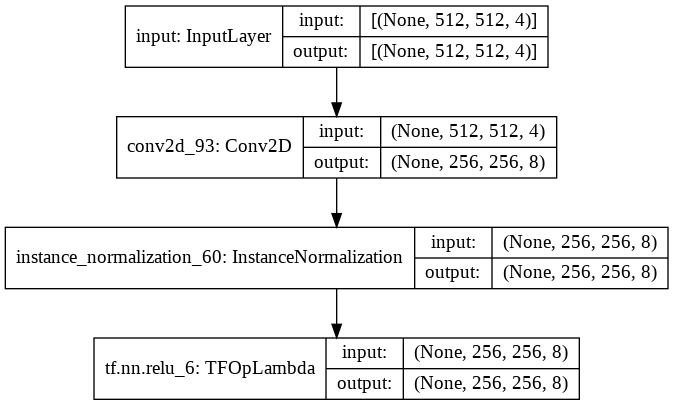

In [89]:
class DownSampleBlock(tf.keras.layers.Layer):
  def __init__(self, numOfChannels, channelExpansionFactor = 2, kernel_size = (3,3), strides = (2,2), kernel_initializer = KERNEL_INIT, gamma_initializer = GAMMA_INIT, activation = 'relu'):
    super(DownSampleBlock, self).__init__()
    
    self.activation = activation
    filters = channelExpansionFactor * numOfChannels

    self.conv = tf.keras.layers.Conv2D(
        filters, 
        kernel_size, 
        strides=strides,
        kernel_initializer = kernel_initializer,
        padding='same', 
        use_bias = False
        )
    
    self.InstNorm = tfa.layers.InstanceNormalization(
        gamma_initializer = gamma_initializer
        )
    
    self.act = tf.keras.activations.get(self.activation)

  def call(self, input_tensor):
    x = self.conv(input_tensor)
    x = self.InstNorm(x)
    x = self.act(x)
    return x


  def build_model_from_layer(self, inputDim):
    x = tf.keras.layers.Input(shape=(inputDim), name = "input")
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test
# Test input has the shape of the 1 training example of the dataset
dataShape = (512,512,4)
test_Input = tf.keras.layers.Input(shape=dataShape)

downBlock = DownSampleBlock(numOfChannels = dataShape[2], kernel_size = (3,3))
test_output = downBlock(test_Input)
print("Input Shape:{}".format(test_Input.shape))
print("Output Shape:{}".format(test_output.shape))
print("Expected Output Shape:(None,{},{},{})".format(int(dataShape[0]/2), int(dataShape[1]/2), int(2*dataShape[2])))

layerModel = downBlock.build_model_from_layer(dataShape)
layerModel.summary()
tf.keras.utils.plot_model(layerModel, show_shapes=True)


<a name="4-2-2"></a>
### 4.2.2 Up-Sample Model Block

Input Shape:(None, 512, 512, 4)
Output Shape:(None, 1024, 1024, 2)
Expected Output Shape:(None,1024,1024,2)
Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 4)]     0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 1024, 1024, 2)     72        
_________________________________________________________________
instance_normalization_63 (I (None, 1024, 1024, 2)     4         
_________________________________________________________________
tf.nn.relu_14 (TFOpLambda)   (None, 1024, 1024, 2)     0         
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


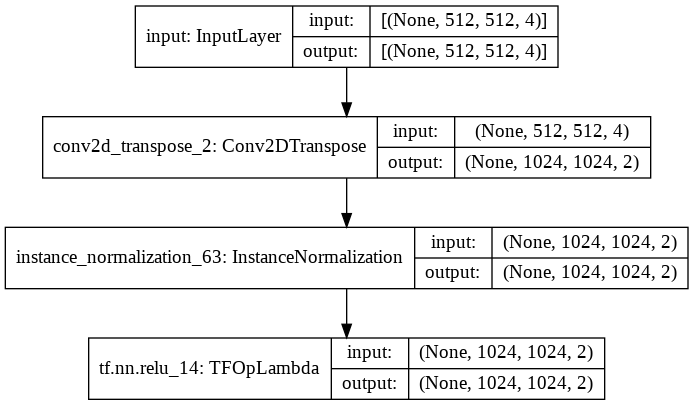

In [112]:
class UpSampleBlock(tf.keras.layers.Layer):
  def __init__(self, numOfChannels, channelReductionFactor = 2, kernel_size = (3,3), strides = (2,2), kernel_initializer = KERNEL_INIT, gamma_initializer = GAMMA_INIT, activation = 'relu'):
    super(UpSampleBlock, self).__init__()
    
    self.activation = activation
    filters = int(numOfChannels / channelReductionFactor)

    self.convTrans = tf.keras.layers.Conv2DTranspose(
        filters, 
        kernel_size, 
        strides=strides,
        kernel_initializer = kernel_initializer,
        padding='same', 
        use_bias = False
        )
    
    self.InstNorm = tfa.layers.InstanceNormalization(
        gamma_initializer = gamma_initializer
        )
    
    self.act = tf.keras.activations.get(self.activation)

  def call(self, input_tensor):
    x = self.convTrans(input_tensor)
    x = self.InstNorm(x)
    x = self.act(x)
    return x


  def build_model_from_layer(self, inputDim):
    x = tf.keras.layers.Input(shape=(inputDim), name = "input")
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test
# Test input has the shape of the 1 training example of the dataset
dataShape = (512,512,4)
test_Input = tf.keras.layers.Input(shape=dataShape)

upBlock = UpSampleBlock(numOfChannels = dataShape[2], kernel_size = (3,3))
test_output = upBlock(test_Input)
print("Input Shape:{}".format(test_Input.shape))
print("Output Shape:{}".format(test_output.shape))
print("Expected Output Shape:(None,{},{},{})".format(int(dataShape[0]*2), int(dataShape[1]*2), int(dataShape[2]/2)))

layerModel = upBlock.build_model_from_layer(dataShape)
layerModel.summary()
tf.keras.utils.plot_model(layerModel, show_shapes=True)

<a name="4-2-4"></a>
### 4.2.4 Residual Identity Model Block

Der unten gezeigte Residualblock unterscheidet sich noch von dem CycleGAN Beispiel...

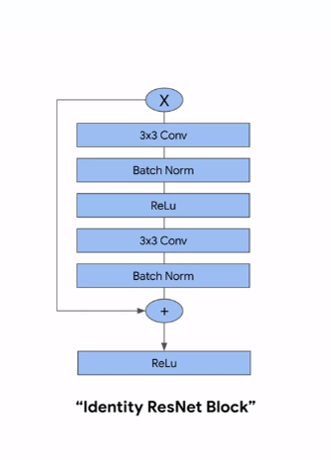

Model: "model_113"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d_840 (Conv2D)             (None, 512, 512, 4)  148         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_602 (BatchN (None, 512, 512, 4)  16          conv2d_840[0][0]                 
__________________________________________________________________________________________________
tf.nn.relu_19 (TFOpLambda)      (None, 512, 512, 4)  0           batch_normalization_602[0][0]    
__________________________________________________________________________________________

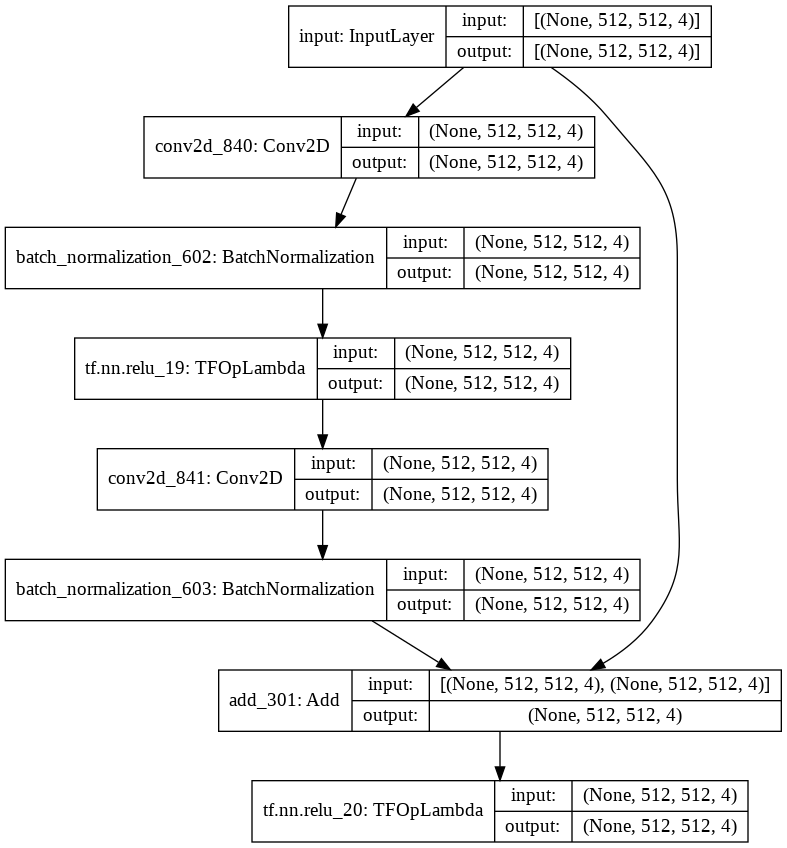

In [179]:
class ResidualIdentityBlock(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, strides = (1,1), activation = 'relu'):
    super(ResidualIdentityBlock, self).__init__()

    self.activation = activation

    self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding = 'same')
    self.bn1 = tf.keras.layers.BatchNormalization()


    self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding = 'same')
    self.bn2 = tf.keras.layers.BatchNormalization()

    self.add = tf.keras.layers.Add()
    

  def call(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = tf.keras.activations.get(self.activation)(x)

    x = self.conv2(x)
    x = self.bn2(x)

    x = self.add([x, input_tensor])
    x = tf.keras.activations.get(self.activation)(x)

    return x

  def build_model_from_layer(self, inputDim):
    x = tf.keras.layers.Input(shape=(inputDim), name = "input")
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test Code
# Test input has the shape of the 1 training example of the dataset
dataShape = (512,512,4)
test_Input = tf.keras.layers.Input(shape=dataShape)

resnetBlock = ResidualIdentityBlock(filters = 4, kernel_size = (3,3), activation = 'relu')

layerModel = resnetBlock.build_model_from_layer(dataShape)
layerModel.summary()
tf.keras.utils.plot_model(layerModel, show_shapes=True)


<a name="4-3"></a>
## 4.3 Custom Losses

<a name="4-4"></a>
## 4.4 Custom Model

<a name="4-4-1"></a>
### 4.4.1 U-Net

Model: "model_134"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_285 (InputLayer)          [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
down_sample_block_307 (DownSamp (None, 256, 256, 8)  304         input_285[0][0]                  
__________________________________________________________________________________________________
down_sample_block_308 (DownSamp (None, 128, 128, 16) 1184        down_sample_block_307[0][0]      
__________________________________________________________________________________________________
down_sample_block_309 (DownSamp (None, 64, 64, 32)   4672        down_sample_block_308[0][0]      
__________________________________________________________________________________________

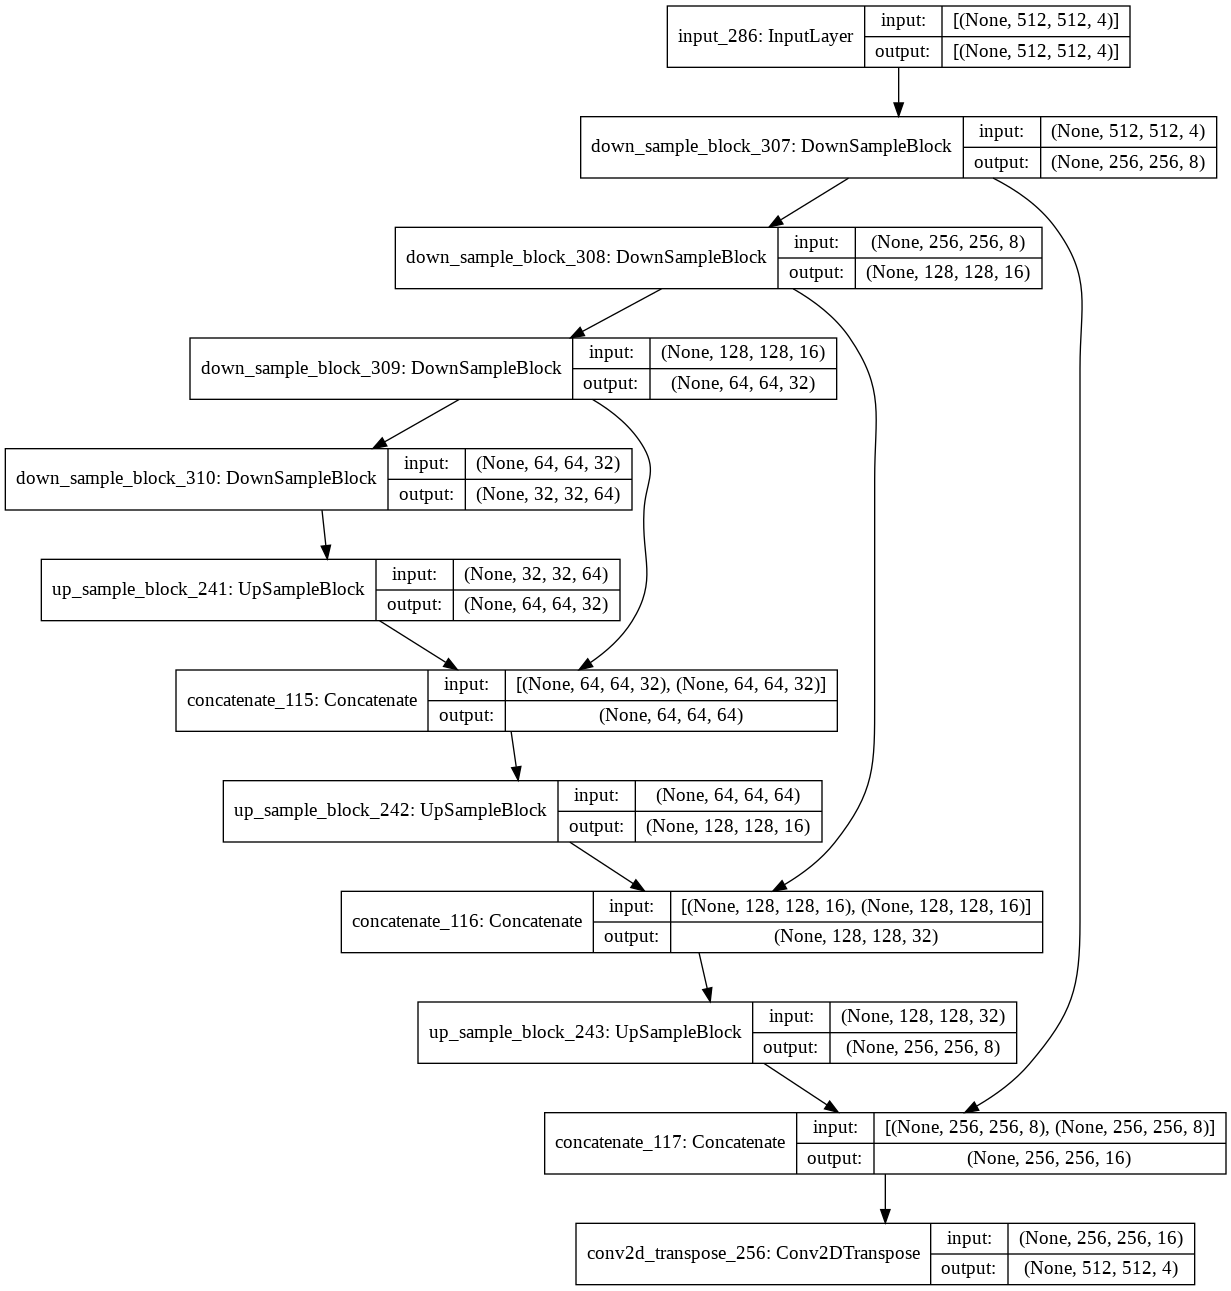

In [192]:
class UNet(tf.keras.Model):
  def __init__(self, filters = 4, num_up_down_blocks = 4): #TODO: add missing arguments
    super(UNet, self).__init__()
    
    #double the filtersize with ervery downsample step
    self.downBlocks = [DownSampleBlock(filters * (2**x) ) for x in range(num_up_down_blocks)]
    
    #filter size is reduced with every upsampling step. Note that range is reversed!
    self.upBlocks = [UpSampleBlock(filters * (2**(x+1))) for x in reversed(range(num_up_down_blocks))]

    # las layer is to get the original image shape back. Without there are 8 channels not 4 due to the concat!!
    self.finalLayer = tf.keras.layers.Conv2DTranspose(filters, 4, strides=2, kernel_initializer = KERNEL_INIT, padding='same', activation='sigmoid' )


  def call(self, input_tensor):
    x = input_tensor
    
    # store skip connections during down sampling, and concatenate during upsampling
    skips = []

    #Downsampling Blocks
    for down in self.downBlocks:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(self.upBlocks, skips):
      x = up(x)
      x = tf.keras.layers.Concatenate()([x, skip])

    x = self.finalLayer(x)

    return x

  def build_model_from_layers(self, shape):
    x = tf.keras.layers.Input(shape=(shape))
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test Code
# Test input has the shape of the 1 training example of the dataset
dataShape = (512, 512, 4)
test_Input = tf.keras.layers.Input(shape=dataShape)

UNet = UNet(filters = dataShape[2] ,num_up_down_blocks = 4)
UNet.build_model_from_layers(dataShape).summary()
tf.keras.utils.plot_model(UNet.build_model_from_layers(dataShape), show_shapes=True, expand_nested=True)

# Test forward Propagation
#rgbd_samples = Combine_color_depth(DATA_PATH)
#Plot_RGBD_Sample(rgbd_samples[24,:,:,:])
#output = UNet.predict(rgbd_samples)
#Plot_RGBD_Sample(output[24,:,:,:])
#print(output)
  

<a name="4-4-2"></a>
### 4.4.2 ResNet

TODO: 


1.   Add Upsampling Layer
2.   Add Downsampling Layer

MERKE: 
Don't trust summary() and plot_graph()!!!



Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_225 (InputLayer)       [(None, 512, 512, 4)]     0         
_________________________________________________________________
down_sample_block_197 (DownS (None, 256, 256, 8)       304       
_________________________________________________________________
down_sample_block_198 (DownS (None, 128, 128, 16)      1184      
_________________________________________________________________
down_sample_block_199 (DownS (None, 64, 64, 32)        4672      
_________________________________________________________________
down_sample_block_200 (DownS (None, 32, 32, 64)        18560     
_________________________________________________________________
residual_identity_block_298  (None, 32, 32, 64)        74368     
_________________________________________________________________
residual_identity_block_299  (None, 32, 32, 64)        74

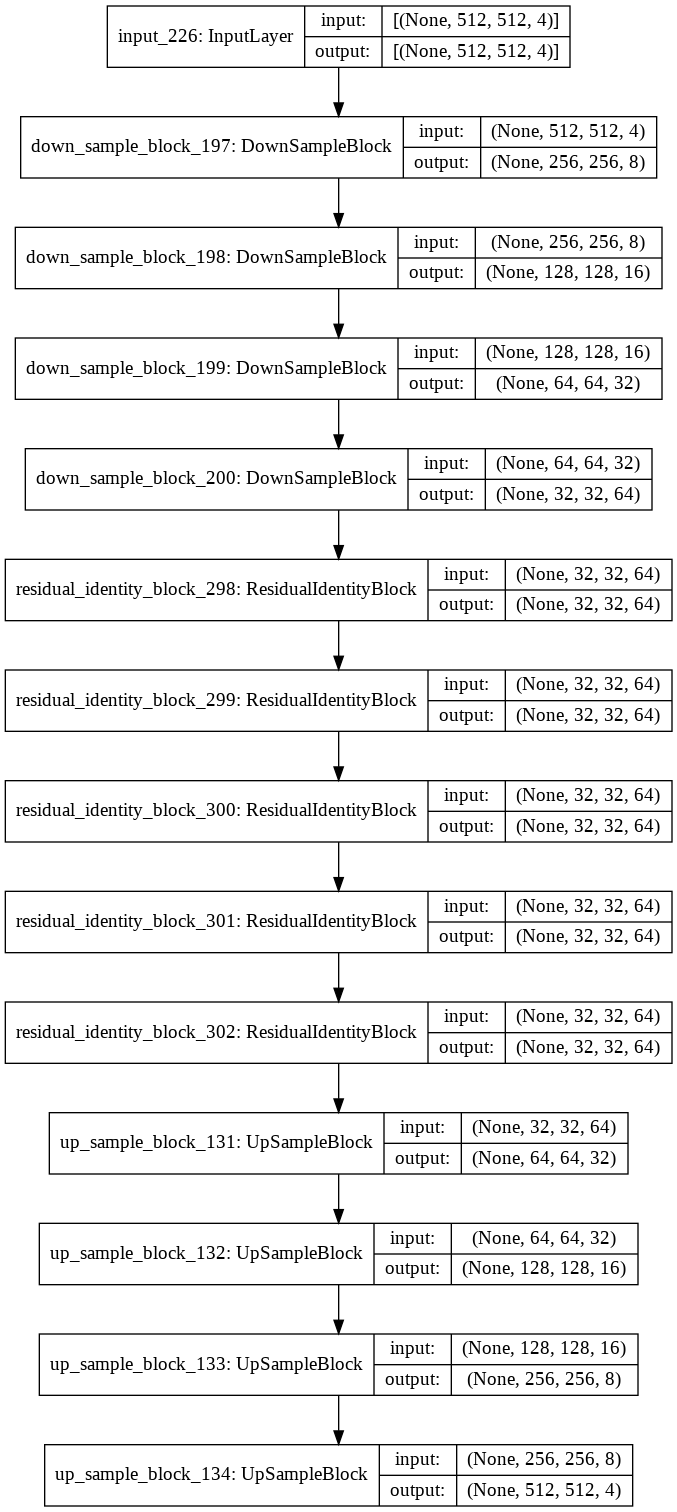

In [166]:
class ResNet(tf.keras.Model):
  def __init__(self, filters = 4, num_up_down_blocks = 4, num_res_blocks = 5, weight_sharing_active = False):
    super(ResNet, self).__init__()
    self.num_res_blocks = num_res_blocks
    self.weight_sharing_active = weight_sharing_active
    #self.num_up_down_blocks = num_up_down_blocks

    #double the filtersize with ervery downsample step
    self.downBlocks = [DownSampleBlock(filters * (2**x) ) for x in range(num_up_down_blocks)]

    #--------------------------------------------------
    #filter size after all downsampling steps
    filterSizeResBlock = filters * (2**num_up_down_blocks)
    if (weight_sharing_active):
      self.resBlocks = ResidualIdentityBlock(filterSizeResBlock, kernel_size =(3,3))
    else:
      self.resBlocks = [ResidualIdentityBlock(filterSizeResBlock, kernel_size = (3,3)) for _ in range(num_res_blocks)]
    #--------------------------------------------------
    
    #filter size is reduced with every upsampling step. Note that range is reversed!
    self.upBlocks = [UpSampleBlock(filters * (2**(x+1))) for x in reversed(range(num_up_down_blocks))]


  def call(self, input_tensor):
    x = input_tensor

    #Downsampling Blocks
    for down in self.downBlocks:
        x = down(x)

    #Residual Blocks
    if (self.weight_sharing_active):
      for _ in range(0,self.num_res_blocks):
        x = self.resBlocks(x)
    else:
      for layer in self.resBlocks:
        x = layer(x)

    # Upsampling Blocks
    for up in self.upBlocks:
        x = up(x)

    return x

  def build_model_from_layers(self, shape):
    x = tf.keras.layers.Input(shape=(shape))
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test Code
# Test input has the shape of the 1 training example of the dataset
dataShape = (512, 512, 4)
test_Input = tf.keras.layers.Input(shape=dataShape)

ResNet = ResNet(filters = dataShape[2] ,num_res_blocks = 5, weight_sharing_active = False)
ResNet.build_model_from_layers(dataShape).summary()
tf.keras.utils.plot_model(ResNet.build_model_from_layers(dataShape), show_shapes=True, expand_nested=True)

# Test forward Propagation
#rgbd_samples = Combine_color_depth(DATA_PATH)
#Plot_RGBD_Sample(rgbd_samples[24,:,:,:])
#output = ResNet.predict(rgbd_samples)
#Plot_RGBD_Sample(output[24,:,:,:])
#print(output)

<a name="4-4-3"></a>
### 4.4.3 PatchGAN Discriminator

<a name="4-4-4"></a>
### 4.4.4 CycleGAN

<a name="4-2"></a>
## 4.2 Custom Callbacks

<a name="5"></a>
# 5. Training the Model

<a name="6"></a>
# 6. Validating the Model

<a name="A"></a>
# A. TESTING AND DEBUGGING

In [ ]:
#Prepare_filename(directory):
rgbd_samples = Combine_color_depth(DATA_PATH)
Plot_RGBD_Sample(rgbd_samples[24,:,:,:])
Plot_Multiple_RGBD(rgbd_samples)
#Create_tensorflow_dataset(rgbd_samples)